**GENERAL THOUGHTS:**
- ...


**DATA PREPROCESSING:**

Imbalanced data:
- over_sampling for imbalanced data
- cost-sensitive learning for imbalanced data

categorical data:
- Ordinal Data: The categories have an inherent order
- Nominal Data: The categories do not have an inherent order



**MULTI-CLASS CLASSIFIER:**
- Focus on "Native Multiclass Classifiers" as a starting point. Might try "Binary Transformation" or "Hierarchical Classification" later. https://www.projectpro.io/article/multi-class-classification-python-example/547
- Overview models to be considered:  
  - [X] Decision Trees

In [1]:
import os
import pickle
from datetime import datetime

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import sklearn
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# import xgboost as xgb
# import lightgbm as lgbm

import optuna
# from optuna.samplers import TPESampler

import imblearn
from imblearn.over_sampling import RandomOverSampler

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform


In [4]:
SEED = 42

clf_name = "dt_clf"

# Get current date and time
now = datetime.now()
# Format date and time
formatted_date_time = now.strftime("%Y-%m-%d_%H:%M:%S")
print(formatted_date_time)

2023-07-14_11:32:39


# Load data

In [5]:
df = pd.read_csv('../../data/output/df_ml.csv', sep='\t')

# Prep data for machine learning

## Clean data

In [6]:
df['material_number'] = df['material_number'].astype('object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82977 entries, 0 to 82976
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   material_number         82977 non-null  object 
 1   material_number_text    82977 non-null  object 
 2   brand                   82977 non-null  object 
 3   product_area            82977 non-null  object 
 4   core_segment            82977 non-null  object 
 5   component               82977 non-null  object 
 6   component_text          82977 non-null  object 
 7   manufactoring_location  82977 non-null  object 
 8   characteristic_value    82977 non-null  object 
 9   material_weight         75913 non-null  float64
 10  packaging_code          82977 non-null  object 
 11  packaging_category      82977 non-null  object 
dtypes: float64(1), object(11)
memory usage: 7.6+ MB


In [8]:
df_sub = df[[
    'material_number',
    'brand',
    'product_area',
    'core_segment',
    'component',
    'manufactoring_location',
    'characteristic_value',
    'material_weight', 
    'packaging_code',
    'packaging_category',
]]

<Figure size 1000x500 with 0 Axes>

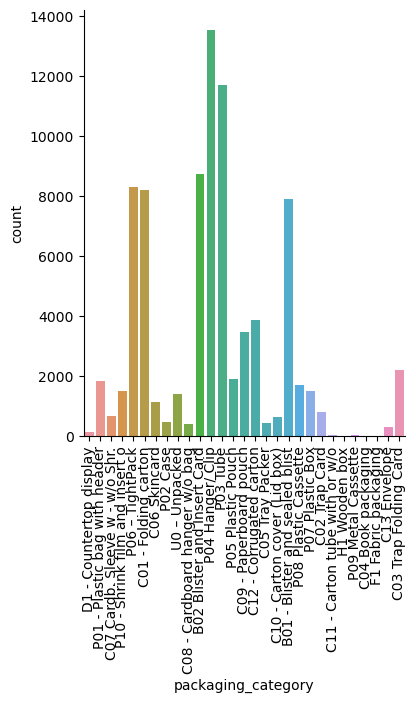

In [9]:
plt.figure(figsize=(10,5))
cat_chart = sns.catplot(
    data=df_sub,
    x='packaging_category',
    kind='count',
)
cat_chart.set_xticklabels(rotation=90)

## Split data into train/test

In [10]:
# Define features and target
X = df_sub.iloc[:, :-1]
y = df_sub.iloc[:, -1]  # the last column is the target

In [11]:
distribution_classes = y.value_counts()
print('Class distribution before oversmapling')
print(distribution_classes.to_dict())

# NOTE: Oversampling so each class has at least 100 sample; to properly apply CV and evaluation
dict_oversmapling = {
    'P09 Metal Cassette': 100,
    'C11 - Carton tube with or w/o': 100,
    'H1 Wooden box': 100,
    'F1 Fabric packaging': 100,
    'C04 Book packaging': 100
}
# define oversampling strategy
oversampler = RandomOverSampler(sampling_strategy=dict_oversmapling, random_state=SEED)
# fit and apply the transform
X_oversample, y_oversample = oversampler.fit_resample(X, y)

distribution_classes = y_oversample.value_counts()
print('\n')
print('Class distribution after oversmapling')
print(distribution_classes.to_dict())

Class distribution before oversmapling
{'P04 Hanger/ Clip': 13543, 'P03 Tube': 11687, 'B02 Blister and Insert Card': 8744, 'P06 – TightPack': 8296, 'C01 - Folding carton': 8219, 'B01 - Blister and sealed blist': 7912, 'C12 - Corrugated carton': 3872, 'C09 - Paperboard pouch': 3478, 'C03 Trap Folding Card': 2188, 'P05 Plastic Pouch': 1904, 'P01 - Plastic bag with header': 1850, 'P08 Plastic Cassette': 1708, 'P10 - Shrink film and insert o': 1499, 'P07 Plastic Box': 1491, 'U0 – Unpacked': 1415, 'C06 Skincard': 1143, 'C02 Trap Card': 804, 'C07 Cardb. Sleeve w - w/o Shr.': 676, 'C10 - Carton cover (Lid box)': 652, 'P02 Case': 485, 'C05 Tray Packer': 431, 'C08 - Cardboard hanger w/o bag': 400, 'C13 Envelope': 295, 'D1 - Countertop display': 150, 'P09 Metal Cassette': 50, 'C11 - Carton tube with or w/o': 44, 'H1 Wooden box': 16, 'F1 Fabric packaging': 15, 'C04 Book packaging': 10}


Class distribution after oversmapling
{'P04 Hanger/ Clip': 13543, 'P03 Tube': 11687, 'B02 Blister and Insert C

In [12]:
# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_oversample, y_oversample, test_size=0.2, stratify=y_oversample,
    # random_state=SEED
)

## DecisionTree pipeline

In [13]:
# DEFINE PIPELINE

# DEFINE PREPROCESSING PIPELINE
# define numerical feature processing
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
# print(f'There are {len(numerical_features)} numerical features:', '\n')
# print(numerical_features)
numeric_feature_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('log_transform', PowerTransformer()),
    # ('scale', MinMaxScaler())
])
# define categorical feature processing
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()
# print(f'There are {len(categorical_features)} categorical features:', '\n')
# print(categorical_features)
categorical_feature_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    # ('one_hot', OneHotEncoder(handle_unknown='ignore', max_categories=None, sparse=False))
])
# apply both pipeline on seperate columns using "ColumnTransformer"
preprocess_pipeline = ColumnTransformer(transformers=[
    ('number', numeric_feature_pipeline, numerical_features),
    ('category', categorical_feature_pipeline, categorical_features)
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

# DEFINE MODEL PIPELINE

label_ecoder = LabelEncoder()
y_train_transformed = label_ecoder.fit_transform(y_train)
# y_train_transformed = label_ecoder.fit_transform(y_train)

# class_weights
# class_weights = compute_sample_weight(
#     class_weight='balanced',
#     y=y_train_transformed
# )
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_transformed),
    y=y_train_transformed
)
class_weight_dict = dict(enumerate(class_weights))

# DEFINE MODEL PIPELINE
best_params = {
    'max_depth': 50,
    'criterion': 'entropy'
}
# model
dt_clf = DecisionTreeClassifier(
    # n_estimators=10,
    class_weight=class_weight_dict,
    **best_params,
    # random_state=SEED
)

# Training
dt_clf.fit(X_train_transformed, y_train_transformed)

DecisionTreeClassifier(class_weight={0: 0.36320204826496705,
                                     1: 0.3286731902097557,
                                     2: 0.349668283728858,
                                     3: 3.5755349385960207,
                                     4: 1.3137536945812809,
                                     5: 28.738362068965518,
                                     6: 6.663968015992004,
                                     7: 2.5153927412661283,
                                     8: 4.249665370641851,
                                     9: 7.1845905172413795,
                                     10: 0.8264086863829049,
                                     11: 4.404346677236094,
                                     12: 28.738362068965518,
                                     13: 0.7421139333496583,
                                     14: 9.741817650496786,
                                     15: 19.15890804597701,
                                     16: 28.738362068965518,
                                     17: 28.738362068965518,
                                     18: 1.5534249767008388,
                                     19: 5.92543547813722,
                                     20: 0.24588972893232527,
                                     21: 0.2122086916667197,
                                     22: 1.5095659655398828,
                                     23: 0.34640183298436666,
                                     24: 1.9271324103245946,
                                     25: 1.6830665926187711,
                                     26: 28.738362068965518,
                                     27: 1.9174887118575825,
                                     28: 2.0309796515169976},
                       criterion='entropy', max_depth=50)

In [14]:
# preprocess & make predictions for test data
X_test_transformed = preprocess_pipeline.transform(X_test)
preds_y_test_dt = dt_clf.predict(X_test_transformed)

y_test_transformed = label_ecoder.transform(y_test)
preds_y_test_dt_inverse = label_ecoder.inverse_transform(preds_y_test_dt)

# score the pipeline
print("Train score (f1-score): ", dt_clf.score(X_train_transformed, y_train_transformed))
print("Test score (f1-score): ", dt_clf.score(X_test_transformed, y_test_transformed))
print(classification_report(y_test, preds_y_test_dt_inverse))

Train score (f1-score):  1.0
Test score (f1-score):  0.7719719239306497
                                precision    recall  f1-score   support

B01 - Blister and sealed blist       0.77      0.75      0.76      1582
   B02 Blister and Insert Card       0.73      0.75      0.74      1749
          C01 - Folding carton       0.73      0.69      0.71      1644
                 C02 Trap Card       0.52      0.53      0.53       161
         C03 Trap Folding Card       0.74      0.73      0.74       438
            C04 Book packaging       0.95      1.00      0.98        20
               C05 Tray Packer       0.58      0.78      0.67        86
                  C06 Skincard       0.85      0.76      0.81       229
C07 Cardb. Sleeve w - w/o Shr.       0.49      0.49      0.49       135
C08 - Cardboard hanger w/o bag       0.46      0.35      0.40        80
        C09 - Paperboard pouch       0.77      0.80      0.78       696
  C10 - Carton cover (Lid box)       0.60      0.52      0.56  

# Production pipeline

## Training pipeline

### Pipeline  
train model and pipeline on full dataset

In [15]:
# load full dataset (assinged & unassinged SKUs)
df_raw = pd.read_csv('../../data/data_showcase.csv', sep='\t')

# data cleaning (data formats, general transformations, "feature selection")
df_cleaned = df_raw.rename(columns={
    'Product Area': 'product_area',
    'Core Segment': 'core_segment',
    'Brand': 'brand',
    'Material Number': 'material_number',
    'Material No Text': 'material_number_text',
    'Component': 'component',
    'Material Description': 'component_text',
    'Packaging Code': 'packaging_code',
    'Material Characteristic': 'characteristic_value',
    'Material Weight': 'material_weight',
    'Column 21': 'col_21',
    'Weight measure': 'weight_measure',
    'Packaging Category': 'packaging_category',
    'Manufactoring Location': 'manufactoring_location',
    'Column 43': 'col_43'
})

df_cleaned['packaging_category'] = df_cleaned['packaging_category'].astype('object')

df_cleaned['packaging_category'].mask(
    df_cleaned['packaging_category'].isin(['-', np.nan]), 'Unassigned', inplace=True
)

df_cleaned['packaging_category'].mask(
    df_cleaned['packaging_category'].isin(['No Packaging']), 'U0 – Unpacked', inplace=True
)

df_full_sub = df_cleaned[[
    'material_number',
    'brand',
    'product_area',
    'core_segment',
    'component',
    'manufactoring_location',
    'characteristic_value',
    'material_weight', 
    'packaging_code',
    'packaging_category',
]]

# TODO(optional): data quality checks (e.g. ensure features have the right format, size of input data, ...)


# final training data
# split data into "assigned" == X, and "unassinged" == X_prod
df_ml = df_full_sub[df_full_sub.packaging_category != 'Unassigned']
# Define features and target
X = df_ml.iloc[:, :-1]
y = df_ml.iloc[:, -1]  # the last column is the target
# NOTE: Oversampling so each class has at least 100 sample; to properly apply CV and evaluation
dict_oversmapling = {
    'P09 Metal Cassette': 100,
    'C11 - Carton tube with or w/o': 100,
    'H1 Wooden box': 100,
    'F1 Fabric packaging': 100,
    'C04 Book packaging': 100
}
# define oversampling strategy
oversampler = RandomOverSampler(sampling_strategy=dict_oversmapling, random_state=SEED)
# fit and apply the transform
X, y = oversampler.fit_resample(X, y)


# production data (for inference)
df_no_packaging_categories = df_full_sub[df_full_sub.packaging_category == 'Unassigned']
# Define features and target
X_inf = df_no_packaging_categories.iloc[:, :-1]
y_inf = df_no_packaging_categories.iloc[:, -1]  # the last column is the target

In [16]:
# FULL TRAINING PIPELINE

# DEFINE PREPROCESSING PIPELINE
# define numerical feature processing
numerical_features = X.select_dtypes(include='number').columns.tolist()
# print(f'There are {len(numerical_features)} numerical features:', '\n')
# print(numerical_features)
numeric_feature_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('log_transform', PowerTransformer()),
    # ('scale', MinMaxScaler())
])
# define categorical feature processing
categorical_features = X.select_dtypes(exclude='number').columns.tolist()
# print(f'There are {len(categorical_features)} categorical features:', '\n')
# print(categorical_features)
categorical_feature_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    # ('one_hot', OneHotEncoder(handle_unknown='ignore', max_categories=None, sparse=False))
])
# apply both pipeline on seperate columns using "ColumnTransformer"
preprocess_pipeline = ColumnTransformer(transformers=[
    ('number', numeric_feature_pipeline, numerical_features),
    ('category', categorical_feature_pipeline, categorical_features)
])
X_transformed = preprocess_pipeline.fit_transform(X)


# TARGET PIPELINE
label_ecoder = LabelEncoder()
y_transformed = label_ecoder.fit_transform(y)


# DEFINE MODEL PIPELINE
# calc class weights
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_transformed),
    y=y_transformed
)
class_weight_dict = dict(enumerate(class_weights))
# model
best_params = {
    'max_depth': 50,
    'criterion': 'entropy'
}
dt_clf = DecisionTreeClassifier(
    # n_estimators=10,
    **best_params,
    class_weight=class_weight_dict,
    # random_state=SEED
)
# training
dt_clf.fit(X_transformed, y_transformed)

DecisionTreeClassifier(class_weight={0: 0.3632282695861372,
                                     1: 0.32866675079660534,
                                     2: 0.3496607943746827,
                                     3: 3.5744553096586036,
                                     4: 1.313465296602156, 5: 28.73862068965517,
                                     6: 6.667893431474518,
                                     7: 2.5143150209672065, 8: 4.25127524994899,
                                     9: 7.184655172413793,
                                     10: 0.8262973171263707,
                                     11: 4.407763909456315,
                                     12: 28.73862068965517,
                                     13: 0.742216443431177,
                                     14: 9.741905318527177,
                                     15: 19.159080459770117,
                                     16: 28.73862068965517,
                                     17: 28.73862068965517,
                                     18: 1.553438956197577,
                                     19: 5.925488801990757,
                                     20: 0.24590246162107618,
                                     21: 0.2122027666665818,
                                     22: 1.5093813387423936,
                                     23: 0.3464153892195657,
                                     24: 1.9274728832766714,
                                     25: 1.6825890333521765,
                                     26: 28.73862068965517,
                                     27: 1.9171861700904052,
                                     28: 2.0309979285975386},
                       criterion='entropy', max_depth=50)

### save pipeline & model

In [17]:
# save pre-processing pipeline

# pipeline
final_preprocessing_pipeline = preprocess_pipeline

# get patch for ml model directory
path_ml_pipeline = "../../ml_pipelines"
# Check whether the specified path exists or not
isExist = os.path.exists(path_ml_pipeline)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(path_ml_pipeline)

pickle.dump(final_preprocessing_pipeline, open(f'{path_ml_pipeline}/final_preprocessing_pipeline_{clf_name}_{formatted_date_time}.pkl', 'wb'))
pickle.dump(label_ecoder, open(f'{path_ml_pipeline}/final_label_ecoder_{clf_name}_{formatted_date_time}.pkl', 'wb'))

In [18]:
# save model

# model
best_model = dt_clf

# get patch for ml model directory
path_ml_pipeline = "../../ml_pipelines"
# Check whether the specified path exists or not
isExist = os.path.exists(path_ml_pipeline)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(path_ml_pipeline)

# print('Model score:', best_model.score(X_test_scaled, y_test))
pickle.dump(best_model, open(f'{path_ml_pipeline}/best_model_{clf_name}_{formatted_date_time}.pkl', 'wb'))

# Inference pipeline

## Inference testing by using the training data

## Inference for SKUs with unassigned packaging categories

In [19]:
# load full dataset (assinged & unassinged SKUs)
df_raw = pd.read_csv('../../data/data_showcase.csv', sep='\t')

# data cleaning (data formats, general transformations, "feature selection")
df_cleaned = df_raw.rename(columns={
    'Product Area': 'product_area',
    'Core Segment': 'core_segment',
    'Brand': 'brand',
    'Material Number': 'material_number',
    'Material No Text': 'material_number_text',
    'Component': 'component',
    'Material Description': 'component_text',
    'Packaging Code': 'packaging_code',
    'Material Characteristic': 'characteristic_value',
    'Material Weight': 'material_weight',
    'Column 21': 'col_21',
    'Weight measure': 'weight_measure',
    'Packaging Category': 'packaging_category',
    'Manufactoring Location': 'manufactoring_location',
    'Column 43': 'col_43'
})

df_cleaned['packaging_category'] = df_cleaned['packaging_category'].astype('object')

df_cleaned['packaging_category'].mask(
    df_cleaned['packaging_category'].isin(['-', np.nan]), 'Unassigned', inplace=True
)

df_cleaned['packaging_category'].mask(
    df_cleaned['packaging_category'].isin(['No Packaging']), 'U0 – Unpacked', inplace=True
)

df_full_sub = df_cleaned[[
    'material_number',
    'brand',
    'product_area',
    'core_segment',
    'component',
    'manufactoring_location',
    'characteristic_value',
    'material_weight', 
    'packaging_code',
    'packaging_category',
]]

In [20]:
df_inf = df_full_sub[df_full_sub.packaging_category == 'Unassigned']
# Define features and target
X_inf = df_inf.iloc[:, :-1]

In [21]:
# TODO: implement data quality check (corresponding to the pre-pipeline steps)

# load pre-processing pipeline
loaded_preprocessing_pipeline = pickle.load(open(f'{path_ml_pipeline}/final_preprocessing_pipeline_{clf_name}_{formatted_date_time}.pkl', 'rb'))
loaded_lable_encoder = pickle.load(open(f'{path_ml_pipeline}/final_label_ecoder_{clf_name}_{formatted_date_time}.pkl', 'rb'))

# load model
loaded_model = pickle.load(open(f'{path_ml_pipeline}/best_model_{clf_name}_{formatted_date_time}.pkl', 'rb'))                 

In [22]:
# inference
X_inf_transformed = loaded_preprocessing_pipeline.transform(X_inf)
preds_y_inf = loaded_model.predict(X_inf_transformed)
preds_y_inf_inverse = loaded_lable_encoder.inverse_transform(preds_y_inf)
# inference proba
preds_y_inf_proba = loaded_model.predict_proba(X_inf_transformed)

In [23]:
# df only containung unassigned; alternative: create 3 df (output files): 1. full as above (assinged & unassinged), 2. only containing assinged 3. only containung unassigned
df_unassigned_SKUs_with_predicted_classes = pd.DataFrame(X_inf.material_number)
df_unassigned_SKUs_with_predicted_classes['predected_packaging_categories'] = preds_y_inf_inverse
df_unassigned_SKUs_with_predicted_classes['predected_packaging_categories_probabilities'] = preds_y_inf_proba.max(axis=1)

In [24]:
df_unassigned_SKUs_with_predicted_classes.head()

,material_number,predected_packaging_categories,predected_packaging_categories_probabilities
366,24640592,B02 Blister and Insert Card,1.0
367,24640592,U0 – Unpacked,1.0
368,24640592,C07 Cardb. Sleeve w - w/o Shr.,1.0
787,60750515,C01 - Folding carton,1.0
800,61382503,P09 Metal Cassette,1.0


In [25]:
print('mean: ', df_unassigned_SKUs_with_predicted_classes.predected_packaging_categories_probabilities.mean())
print('count: ', df_unassigned_SKUs_with_predicted_classes.predected_packaging_categories_probabilities.count())

mean:  1.0
count:  7058


In [26]:
print('mean: ',
    df_unassigned_SKUs_with_predicted_classes.loc[
        df_unassigned_SKUs_with_predicted_classes.predected_packaging_categories_probabilities >= 0.50
    ].predected_packaging_categories_probabilities.mean()
)
print('count: ',
    df_unassigned_SKUs_with_predicted_classes.loc[
        df_unassigned_SKUs_with_predicted_classes.predected_packaging_categories_probabilities >= 0.50
    ].predected_packaging_categories_probabilities.count()
)

mean:  1.0
count:  7058


In [27]:
print('mean: ',
    df_unassigned_SKUs_with_predicted_classes.loc[
        df_unassigned_SKUs_with_predicted_classes.predected_packaging_categories_probabilities >= 0.95
    ].predected_packaging_categories_probabilities.mean()
)
print('count: ',
    df_unassigned_SKUs_with_predicted_classes.loc[
        df_unassigned_SKUs_with_predicted_classes.predected_packaging_categories_probabilities >= 0.95
    ].predected_packaging_categories_probabilities.count()
)

mean:  1.0
count:  7058


In [28]:
# save predictions for unassigned SKUs as excel
# df_unassigned_SKUs_with_predicted_classes.to_excel(f'../../data/output/unassigned_SKUs_with_{clf_name}_{formatted_date_time}_predicted_classes.xlsx', sheet_name='dt_predictions_unassigned_SKUs', index=False, header=True)